In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, classification_report, silhouette_score, precision_recall_curve
from sklearn.model_selection import learning_curve, train_test_split
from scipy.stats import normaltest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering
from pandas.plotting import parallel_coordinates
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping
import pandas_ta as ta
import xgboost as xgb
from fredapi import Fred


# %matplotlib inline

In [3]:
#first download data from imdb
review_size = 20000 #set an upper limit on the length of review as a feature
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=review_size) 

#the data is preprocessed, each integer represents a word
#pad the reviews to fix the data length for the neural network
padding_length = 2000
X_train, X_test = pad_sequences(X_train, maxlen=padding_length, padding="post", truncating="post"), pad_sequences(X_test, maxlen=padding_length, padding="post", truncating="post")

#perform embedding and also build the LSTM model
def build_LSTM():
    LSTM_model = keras.Sequential([Input(shape=(padding_length,)),
        Embedding(input_dim=review_size, output_dim=128, input_length=padding_length),
        
       # Bidirectional wrapper processes sequence both directions
    Bidirectional(LSTM(units=128, 
                       return_sequences=False,
                       dropout=0.25,         # Regularization
                       recurrent_dropout=0.25)),
    
    # Fully connected layer
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),                               
                                   
    # Output layer
    Dense(1, activation='sigmoid')
      ])
    
    LSTM_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005),
                      loss="binary_crossentropy",
                      metrics=["accuracy"])
    
    return LSTM_model

LSTM_model = build_LSTM()
LSTM_model.summary()

/home/devanshu/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-08-11 14:39:43.907810: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 2000, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,848,001 (10.86 MB)

 Trainable params: 2,848,001 (10.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 441s 3s/step - accuracy: 0.5671 - loss: 0.6716 - val_accuracy: 0.5062 - val_loss: 0.6948
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - accuracy: 0.6685 - loss: 0.5919 - val_accuracy: 0.7418 - val_loss: 0.4601
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 434s 3s/step - accuracy: 0.8988 - loss: 0.2678 - val_accuracy: 0.8762 - val_loss: 0.3098
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 435s 3s/step - accuracy: 0.9578 - loss: 0.1377 - val_accuracy: 0.8808 - val_loss: 0.3206


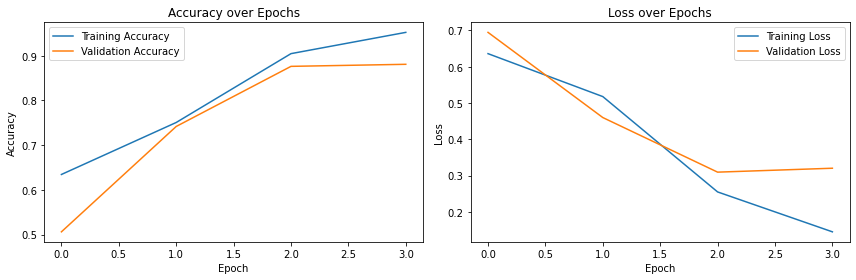

In [4]:
stop_early = EarlyStopping(monitor="val_loss", patience=1) #patience sets the number of epochs of no change in val_loss to wait

#train the LSTM model

training_LSTM = LSTM_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2, verbose=1, callbacks=[stop_early])#, callbacks=[stop_early]

#visualize the results of training
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(training_LSTM)

782/782 ━━━━━━━━━━━━━━━━━━━━ 359s 458ms/step


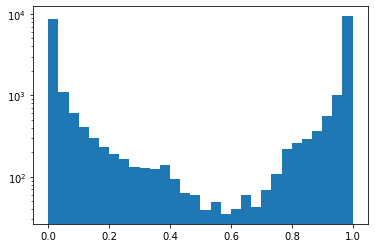

In [5]:
#Tune the threshold for separating positive and negative reviews
#check and compute the class imbalance
#higher precision pushes the threshold to higher values
#higher recall pulls the threshold to lower values

y_train_probability = LSTM_model.predict(X_train).ravel()
plt.hist(y_train_probability,log=True, bins=30)

def set_threshold(switch):
    precision, recall, thresholds = precision_recall_curve(y_train, y_train_probability)

    #maximize the F1 score to achieve precision--recall balance
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_threshold_f1 = thresholds[np.argmax(f1_scores)]
    print(f"Optimal threshold for maximized F1 score: {optimal_threshold_f1:.3f}")

    #Other approach to compute optimal threshold
    #try to aim for as high precision as possible, avoid false positives
    precision_goal = 0.75
    optimal_threshold_precision = thresholds[np.where(precision >= precision_goal)[0][0]]
    print(f"Optimal threshold for higher precision: {optimal_threshold_precision:.3f}")
    
    #cost function approach to compute optimal threshold
    cost_fp = 2.0  # Cost of false positive
    cost_fn = 1.0   # Cost of false negative
    #essentially, penalize false positive more
    # Minimize expected cost
    expected_cost = (cost_fp * (1 - precision) + cost_fn * (1 - recall))
    optimal_idx = np.argmin(expected_cost)
    optimal_threshold_costFn = thresholds[optimal_idx]
    print(f"Cost-optimal threshold: {optimal_threshold:.3f}")
    
    if switch=="f1":
        return optimal_threshold_f1
    elif switch=="precision":
        return optimal_threshold_precision
    elif switch=="cost_func":
        return optimal_threshold_costFn
    else:
        return 0.5




In [6]:
#predict the test dataset results
score_LSTM = LSTM_model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", score_LSTM[0])
print("Test Accuracy:", score_LSTM[1])

#predict the category using the below function

#first create the mapping from word to digits
char_digit = imdb.get_word_index()
digit_char_index = {a:b for b,a in char_digit.items()} 

def review_decrypt(encrypted_review): #takes in the encrypted vectorized review and decodes it to human readable format
    return ' '.join([digit_char_index.get(i-3, '?') for i in encrypted_review])

def review_predict(text):
#     text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    # Step 1: Tokenize text (split into words and convert to lowercase)
    tokens = tf.keras.preprocessing.text.text_to_word_sequence(text, lower=True)
    
    
    # Step 2: Convert words to integers using IMDB's word index
    tokens = [char_digit.get(word, 0) for word in tokens]  # 0 = unknown word
    tokens = [min(idx, review_size - 1) for idx in tokens]  # Force indices to be < vocab_size
#     print(type(tokens))
    # Step 3: Pad/truncate to match model's input length (500)
    padded = pad_sequences([tokens], maxlen=padding_length, padding='post', truncating='post')
#     print(type(padded))
    # Step 4: Predict sentiment (output is between 0 and 1)
    pred = LSTM_model.predict(padded, verbose=0)[0][0]
        # Step 5: Interpret prediction
    sentiment = "Positive" if pred >= set_threshold("f1") else "Negative"
    confidence = pred #if pred > 0.5 else 1 - pred
    
    return f"{sentiment} (Confidence: {confidence:.2f})"



Test Loss: 0.3781123757362366
Test Accuracy: 0.854200005531311


In [7]:

# Example usage
# custom_reviews = [
#     "good movie",
#     "worst worst worst movie",
#     "this movie was fantastic! the acting was brilliant.",
#     "terrible plot and awful acting waste of time.",
#     "it was okay, but the ending could have been better.",
#     "the plot was boring and the acting was terrible",
#     "do not waste your money on this movie"
# ]



custom_reviews = [
    "Christopher Nolan’s The Dark Knight redefines the superhero genre with its gripping narrative, intense action, and Heath Ledger’s iconic performance as the Joker. The film balances psychological depth with blockbuster spectacle, exploring themes of chaos and morality. Hans Zimmer’s score elevates every scene, and the pacing never falters. Minor flaws? Some may find the runtime long, but it’s a small price for such a rich story. A timeless classic.",
    "James Cameron’s Avatar delivers groundbreaking visuals but suffers from a clichéd plot and shallow characters. The world-building is impressive, yet the story feels like a rehash of Pocahontas in space. Dialogue is often cringe-worthy. Worth watching once for the spectacle, but it doesn’t hold up on repeat viewings.",
    "Pixar’s Toy Story 3 tugs at heartstrings with its emotional depth and clever humor. The animation is flawless, and the themes of growing up resonate universally. The climax in the incinerator is one of cinema’s most tense moments. Only gripe? Some jokes feel recycled from earlier films. Still, a near-perfect trilogy finale.",
    "Tommy Wiseau’s The Room is a trainwreck of incoherent plotting, wooden acting, and baffling production choices. The dialogue feels AI-generated, and the green-screen backdrops are laughable. Yet, its sheer incompetence has spawned a cult following. Watch with friends for ironic laughs—alone, it’s unbearable.",
    "Nolan’s Inception dazzles with its dream-within-a-dream concept and stunning visuals (e.g., the rotating hallway fight). However, the emotional core feels underdeveloped—Cobb and Mal’s relationship lacks depth. The supporting cast (Hardy, Page) shines, but some characters are thinly written. A technical marvel that prioritizes intellect over heart."
]

for review in custom_reviews:
#     print(f"Review: {review[:60]}...")
    print(f"Prediction: {review_predict(review)}\n")

Optimal threshold for maximized F1 score: 0.470
Optimal threshold for higher precision: 0.029
Prediction: Positive (Confidence: 0.98)

Optimal threshold for maximized F1 score: 0.470
Optimal threshold for higher precision: 0.029
Prediction: Positive (Confidence: 0.95)

Optimal threshold for maximized F1 score: 0.470
Optimal threshold for higher precision: 0.029
Prediction: Positive (Confidence: 0.99)

Optimal threshold for maximized F1 score: 0.470
Optimal threshold for higher precision: 0.029
Prediction: Negative (Confidence: 0.34)

Optimal threshold for maximized F1 score: 0.470
Optimal threshold for higher precision: 0.029
Prediction: Positive (Confidence: 1.00)



In [ ]:
pr_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()